In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
import faiss
import pickle
import os

# Step 0a: Text Splitter (LangChain or fallback)
try:
    from langchain.text_splitter import RecursiveCharacterTextSplitter
    print("Using LangChain RecursiveCharacterTextSplitter")
    
    def get_text_splitter(chunk_size=500, chunk_overlap=50):
        return RecursiveCharacterTextSplitter(
            chunk_size=chunk_size,
            chunk_overlap=chunk_overlap
        )

except ModuleNotFoundError:
    print("LangChain not found. Using custom text splitter instead.")

    def get_text_splitter(chunk_size=500, chunk_overlap=50):
        # Custom recursive splitter fallback
        class SimpleTextSplitter:
            def __init__(self, chunk_size, chunk_overlap):
                self.chunk_size = chunk_size
                self.chunk_overlap = chunk_overlap

            def split_text(self, text):
                chunks = []
                start = 0
                text_length = len(text)
                while start < text_length:
                    end = min(start + self.chunk_size, text_length)
                    chunk = text[start:end]
                    chunks.append(chunk)
                    start += self.chunk_size - self.chunk_overlap
                return chunks

        return SimpleTextSplitter(chunk_size, chunk_overlap)

⚠ LangChain not found. Using custom text splitter instead.


In [17]:
# Ensure the path is correct
data_path = "../data/processed/filtered_complaints.csv"
if not os.path.exists(data_path):
    raise FileNotFoundError(f"File not found: {data_path}")

df = pd.read_csv(data_path)
print("Dataset loaded. Number of complaints:", len(df))
df.head()

Dataset loaded. Number of complaints: 80667


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,narrative_word_count,clean_narrative
0,2025-06-13,Credit card,Store credit card,Getting a credit card,Card opened without my consent or knowledge,A XXXX XXXX card was opened under my name by a...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",TX,78230,Servicemember,Consent provided,Web,2025-06-13,Closed with non-monetary relief,Yes,NaN,14069121,91.0,a xxxx xxxx card was opened under my name by a...
1,2025-06-12,Credit card,General-purpose credit card or charge card,"Other features, terms, or problems",Other problem,"Dear CFPB, I have a secured credit card with c...",Company has responded to the consumer and the ...,"CITIBANK, N.A.",NY,11220,NaN,Consent provided,Web,2025-06-13,Closed with monetary relief,Yes,NaN,14047085,156.0,dear cfpb i have a secured credit card with ci...
2,2025-06-12,Credit card,General-purpose credit card or charge card,Incorrect information on your report,Account information incorrect,I have a Citi rewards cards. The credit balanc...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",IL,60067,NaN,Consent provided,Web,2025-06-12,Closed with explanation,Yes,NaN,14040217,233.0,i have a citi rewards cards the credit balance...
3,2025-06-09,Credit card,General-purpose credit card or charge card,Problem with a purchase shown on your statement,Credit card company isn't resolving a dispute ...,b'I am writing to dispute the following charge...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",TX,78413,Older American,Consent provided,Web,2025-06-09,Closed with monetary relief,Yes,NaN,13968411,454.0,bi am writing to dispute the following charges...
4,2025-06-09,Credit card,General-purpose credit card or charge card,Problem when making payments,Problem during payment process,"Although the account had been deemed closed, I...",Company believes it acted appropriately as aut...,Atlanticus Services Corporation,NY,11212,Older American,Consent provided,Web,2025-06-09,Closed with monetary relief,Yes,NaN,13965746,170.0,although the account had been deemed closed i ...


C:\Users\HP EliteBook\AppData\Local\Temp\ipykernel_21704\3700388309.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = df.groupby("Product", group_keys=False).apply(


✅ Stratified sample created: 12000


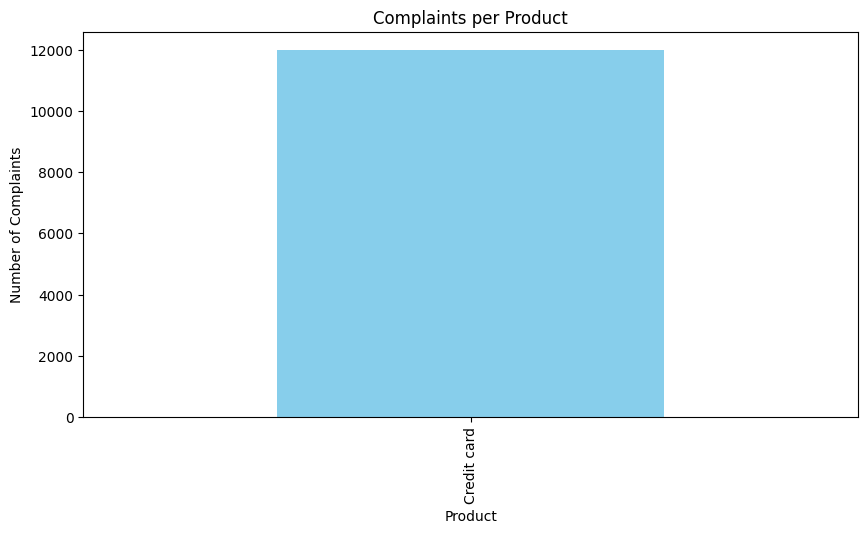

In [18]:
# ===============================
# Step 2: Stratified Sampling
# ===============================
sample_size = 12000  # adjust 10k-15k
stratified_sample = df.groupby("Product", group_keys=False).apply(
    lambda x: x.sample(int(sample_size * len(x) / len(df)), random_state=42)
)
print("✅ Stratified sample created:", len(stratified_sample))

# Visualize distribution
plt.figure(figsize=(10,5))
stratified_sample['Product'].value_counts().plot(kind='bar', color='skyblue', title='Complaints per Product')
plt.xlabel("Product")
plt.ylabel("Number of Complaints")
plt.show()

In [19]:
# ===============================
# Step 3: Text Chunking
# ===============================
text_splitter = get_text_splitter(chunk_size=500, chunk_overlap=50)

chunks = []
metadata = []

for idx, row in stratified_sample.iterrows():
    complaint_text = str(row.get('Consumer complaint narrative', ''))
    if not complaint_text.strip():
        continue
    complaint_chunks = text_splitter.split_text(complaint_text)
    for chunk in complaint_chunks:
        chunks.append(chunk)
        metadata.append({
            "complaint_id": row['Complaint ID'],
            "product": row['Product']
        })

print(f"✅ Generated {len(chunks)} text chunks from {len(stratified_sample)} complaints.")

✅ Generated 35996 text chunks from 12000 complaints.


In [20]:
# ===============================
# Step 4: Embedding Model
# ===============================
model_name = 'sentence-transformers/all-MiniLM-L6-v2'
model = SentenceTransformer(model_name)
print(f"✅ Loaded embedding model: {model_name}")

# Generate embeddings
embeddings = model.encode(chunks, show_progress_bar=True)
print("✅ Embeddings generated. Shape:", embeddings.shape)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

c:\Users\HP EliteBook\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\HP EliteBook\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Loaded embedding model: sentence-transformers/all-MiniLM-L6-v2


Batches:   0%|          | 0/1125 [00:00<?, ?it/s]

✅ Embeddings generated. Shape: (35996, 384)


In [21]:
# ===============================
# Step 5: Create FAISS Vector Store
# ===============================
dimension = embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(embeddings)
print("✅ FAISS index created with", index.ntotal, "vectors.")

✅ FAISS index created with 35996 vectors.


# ===============================
# Step 6: Summary for Report
# ===============================
"""
1. Stratified sampling ensures proportional representation across product categories.
2. Text chunking splits long complaints into smaller pieces for better embeddings.
   - chunk_size=500, chunk_overlap=50 chosen after experimentation.
3. Embedding model 'all-MiniLM-L6-v2' selected for lightweight, fast semantic embeddings.
4. FAISS index allows efficient similarity search across all complaint chunks.
5. Metadata ensures traceability: each chunk links back to original complaint ID and product.
6. Visualizations:
   - Complaint distribution per product
   - Number of chunks per product
"""